In [1]:
import numpy as np
import sys,os
from tqdm import tqdm
import time
import random
sys.path.append(os.pardir)

from __init__ import *
from NEURON.LIF_CORTEX import LIF_cortex as Cortex
from NEURON.LIF_STRIATUM import LIF_striatum as Striatum

import random
import math
import matplotlib.pyplot as plt

pi = np.pi

class Network:
    def __init__(self, num_ctx, num_str):
        self.numCtx = num_ctx
        self.neuronCtx = [Cortex() for i in range(num_ctx)]
        self.numStr = num_str
        self.neuronStr = [Striatum() for i in range(num_str)]
        
        self.generate_weights()

    def generate_weights(self): ## w1:ctx-str w2:str-ctx
        self.w1 = np.zeros((self.numCtx, self.numStr))
        self.w2 = np.zeros((self.numStr, self.numCtx))
        for i in range(self.numCtx):
            for j in range(self.numStr):
                self.w1[i,j] = random.choice([0,0,1])
                self.w2[j,i] = random.choice([0,0,1])

    def fire(self, w):
        time = 15000
        dt = 1

        firings_Ctx = []
        firings_Str = []
        threshold = []
        for t in tqdm(range(time)):
            if t < 5000:
                I_Ctx = np.random.normal(1, 1, self.numCtx) * (np.sin(t*2*pi/333)*0.5 + 1)*2 + np.random.normal(1, 1, self.numCtx)*2## (sin+1)**2 で 0~4の尖ったinput
            else:
                I_Ctx = np.random.normal(1, 1, self.numCtx)*w ## (sin+1)**2 で 0~4の尖ったinput
            
            I_Str = np.random.normal(1, 1, self.numStr) * 2 #ほとんど発火しないくらいのInput
            fired_Ctx = [i for i in range(self.numCtx) if self.neuronCtx[i].v >= self.neuronCtx[i].thrs] #閾値を超えたニューロン番号
            fired_Str = [i for i in range(self.numStr) if self.neuronStr[i].v >= self.neuronStr[i].thrsres] #閾値を超えたニューロン番号
            len_fired_Ctx = len(fired_Ctx)
            len_fired_Str = len(fired_Str)
            len_firings_Ctx = len(firings_Ctx)
            len_firings_Str = len(firings_Str)

            if len_fired_Ctx == 0: 
                pass 
            elif len_firings_Ctx == 0:
                firings_Ctx = [[neuronNumber, t] for neuronNumber in fired_Ctx]
            else:
                fire_time_Ctx = [[neuronNumber, t] for neuronNumber in fired_Ctx]
                firings_Ctx = np.concatenate((firings_Ctx, fire_time_Ctx), axis=0) ##[ニューロン番号、時間]を入れていく(n*2の配列)
                
            if len_fired_Str == 0:
                pass 
            elif len_firings_Str == 0:
                firings_Str = [[neuronNumber, t, self.neuronStr[neuronNumber].res_frq] for neuronNumber in fired_Str]
            else:
                fire_time_Str = [[neuronNumber, t, self.neuronStr[neuronNumber].res_frq] for neuronNumber in fired_Str]
                firings_Str = np.concatenate((firings_Str, fire_time_Str), axis=0)

            # update U and V to the fired ones
            for k in range(len(fired_Ctx)):
                for i in range(math.ceil(1/dt)):
                    self.neuronCtx[fired_Ctx[k]].step(dt, I_Ctx[fired_Ctx[k]], 1)
                    
            for k in range(len(fired_Str)):
                for i in range(math.ceil(1/dt)):
                    self.neuronStr[fired_Str[k]].step(dt, I_Str[fired_Str[k]], 1)

            # update I
            I_Ctx += np.sum(self.w2[fired_Str, :], axis=0)*0.00002
            I_Str += np.sum(self.w1[fired_Ctx, :], axis=0)*2

            for k in range(self.numCtx):
                for i in range(math.ceil(1/dt)):
                    self.neuronCtx[k].step(dt, I_Ctx[k], 1)
                    
            for k in range(self.numStr):
                for i in range(math.ceil(1/dt)):
                    self.neuronStr[k].step(dt, I_Str[k], 1)
            
            # record threshold
            for k in range(self.numStr):
                threshold.append([t, self.neuronStr[k].res_frq, self.neuronStr[k].thrsres])
        
        #record resonant
        res = np.zeros(3)
        for k in range(self.numStr):
            if self.neuronStr[k].res_frq == 2:
                res[0] += 1
            elif self.neuronStr[k].res_frq == 3:
                res[1] += 1
            elif self.neuronStr[k].res_frq == 4:
                res[2] += 1
                
        return firings_Ctx, firings_Str, threshold, res

 16%|█▌        | 2353/15000 [00:32<02:53, 72.94it/s]


 31%|███▏      | 4689/15000 [01:04<02:21, 72.69it/s]


 47%|████▋     | 7025/15000 [01:36<01:47, 73.86it/s]


 62%|██████▏   | 9361/15000 [02:08<01:16, 73.28it/s]


 78%|███████▊  | 11665/15000 [02:40<00:45, 73.56it/s]


 93%|█████████▎| 13953/15000 [03:12<00:14, 73.38it/s]


100%|██████████| 1/1 [03:36<00:00, 216.14s/it]


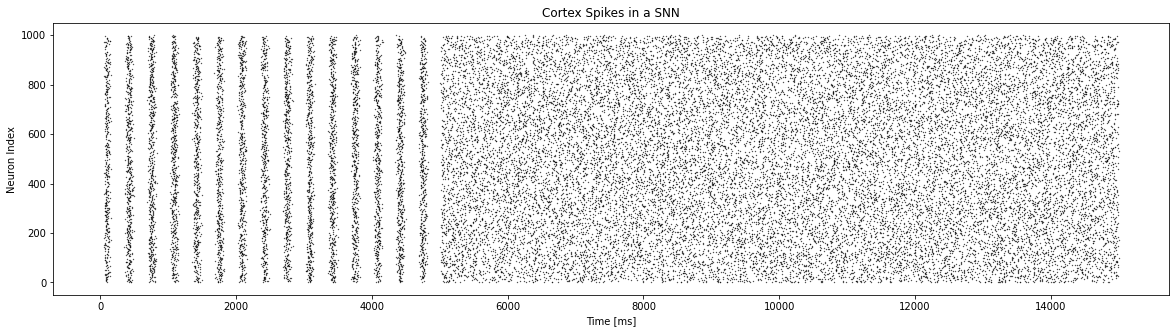

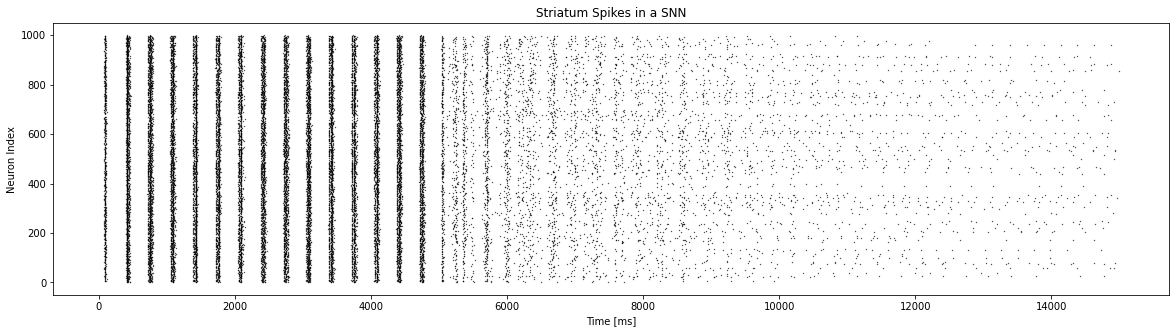

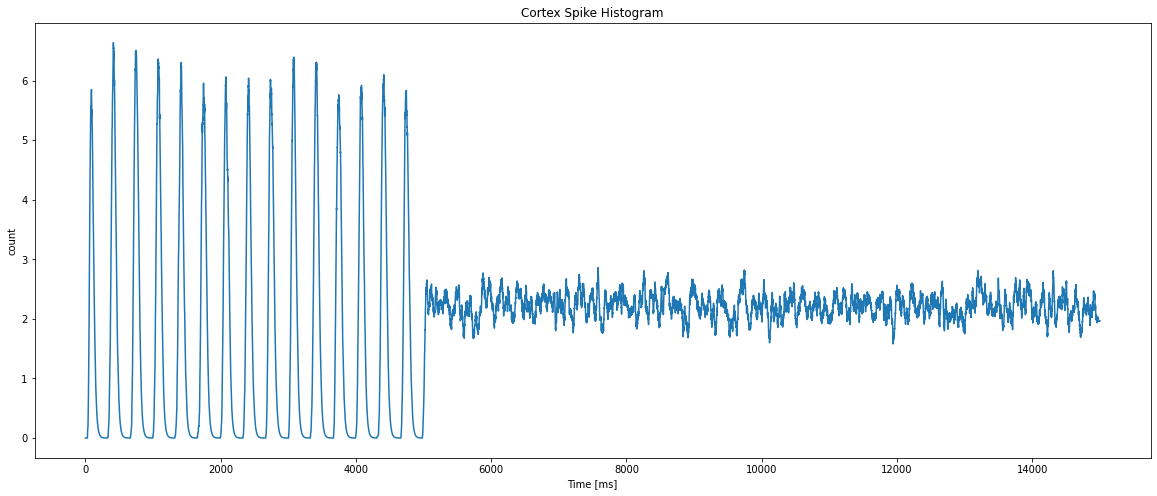

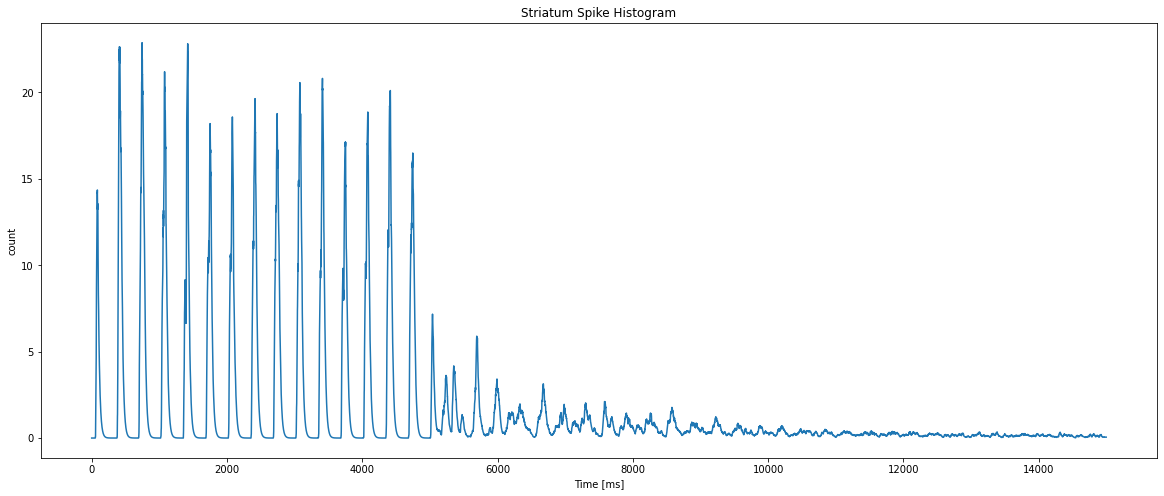

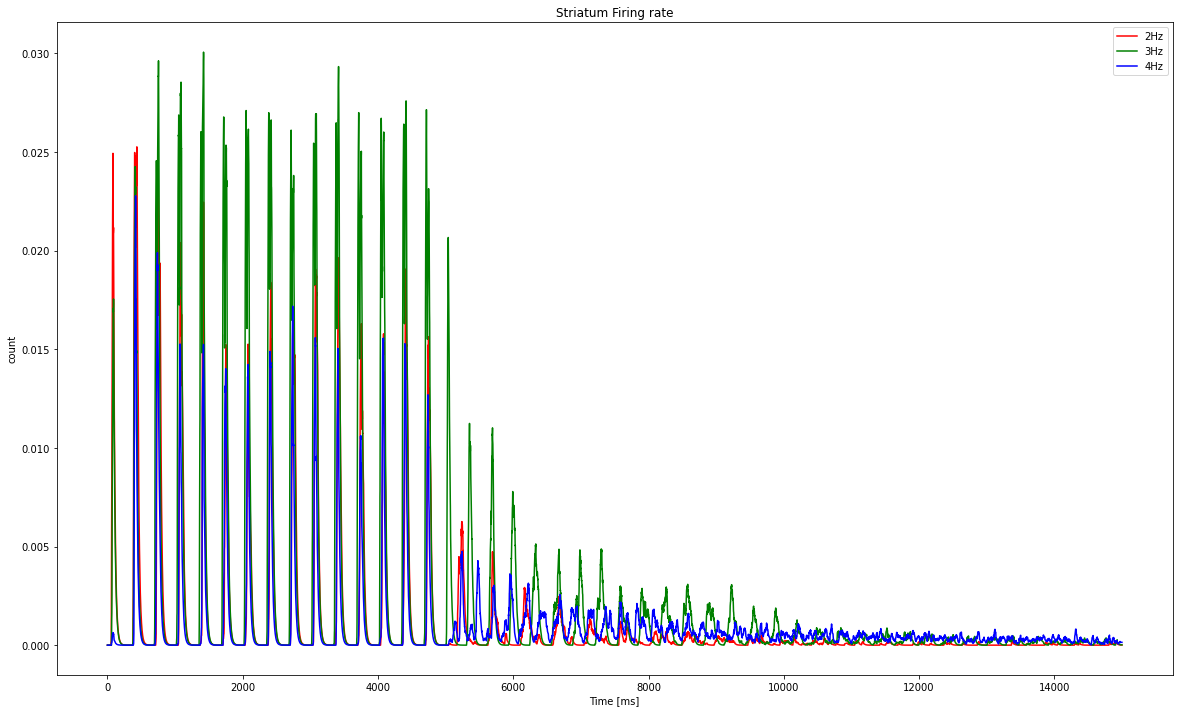

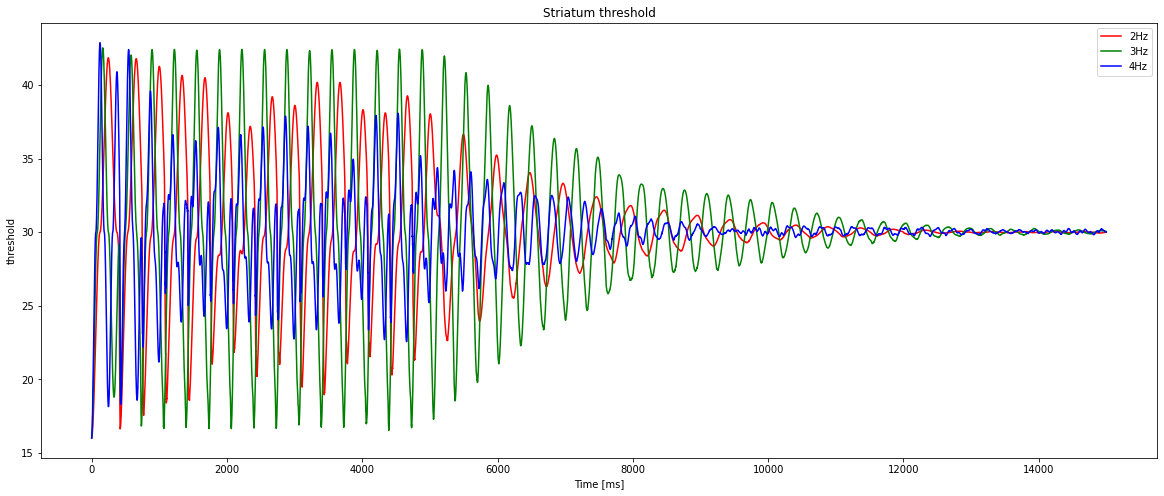

In [2]:
for i in tqdm(range(424, 425)):
    n = Network(1000,1000)
    firings_Ctx, firings_Str, th, res = n.fire(i/100)

    y1 = [firings_Ctx[i][0] for i in range(len(firings_Ctx))]  # neurons
    x1 = [firings_Ctx[i][1] for i in range(len(firings_Ctx))]  # time
    y2 = [firings_Str[i][0] for i in range(len(firings_Str))]  # neurons
    x2 = [firings_Str[i][1] for i in range(len(firings_Str))]  # time
    z = [firings_Str[i][2] for i in range(len(firings_Str))]

    plt.figure(num=1, figsize=(20,5))
    plt.title("Cortex Spikes in a SNN")
    plt.ylabel("Neuron Index")
    plt.xlabel("Time [ms]")
    plt.scatter(x1, y1, s=0.1, color='black')
    plt.savefig(str(i)+"_fig1.png")

    plt.figure(num=2,figsize=(20,5))
    plt.title("Striatum Spikes in a SNN")
    plt.ylabel("Neuron Index")
    plt.xlabel("Time [ms]")
    plt.scatter(x2, y2, s=0.1, color='black')
    plt.savefig(str(i)+"_fig2.png")

    time = 15000
    plt.figure(num=3, figsize = (20,8))
    plt.title("Cortex Spike Histogram")
    plt.ylabel("count")
    plt.xlabel("Time [ms]")
    smooth = 25
    x = np.arange(time)
    y = np.zeros(time)
    for i in range(len(x1)):
        y[x1[i]] += 1

    for i in range(smooth):
        y[i] = np.mean(y[:smooth])
        y[time-1-i] = np.mean(y[time-smooth:])
    for i in range(time-smooth):
        y[i+smooth] = np.mean(y[i:i+smooth*2])
    plt.plot(x,y)
    plt.savefig(str(i)+"_fig3.png")

    plt.figure(num=4, figsize=(20,8))
    plt.title("Striatum Spike Histogram")
    plt.ylabel("count")
    plt.xlabel("Time [ms]")
    x = np.arange(time)
    y = np.zeros(time)
    for i in range(len(x2)):
        y[int(x2[i])] += 1

    for i in range(smooth):
        y[i] = np.mean(y[:smooth])
        y[time-1-i] = np.mean(y[time-smooth:])
    for i in range(time-smooth):
        y[i+smooth] = np.mean(y[i:i+smooth*2])
    plt.plot(x,y)
    plt.savefig(str(i)+"_fig4.png")

    plt.figure(num=5, figsize=(20,12))
    plt.title("Striatum Firing rate")
    plt.ylabel("count")
    plt.xlabel("Time [ms]")
    x = np.arange(time)
    y2 = np.zeros(time)
    y3 = np.zeros(time)
    y4 = np.zeros(time)

    for i in range(len(z)):
        if z[i]==2:
            y2[int(x2[i])] += 1
        elif z[i]==3:
            y3[int(x2[i])] += 1
        elif z[i]==4:
            y4[int(x2[i])] += 1

    for i in range(smooth):
        y2[i] = np.mean(y2[:smooth])
        y2[time-1-i] = np.mean(y2[time-smooth:])
        y3[i] = np.mean(y3[:smooth])
        y3[time-1-i] = np.mean(y3[time-smooth:])
        y4[i] = np.mean(y4[:smooth])
        y4[time-1-i] = np.mean(y4[time-smooth:])
    for i in range(time-smooth):
        y2[i+smooth] = np.mean(y2[i:i+smooth*2])
        y3[i+smooth] = np.mean(y3[i:i+smooth*2])
        y4[i+smooth] = np.mean(y4[i:i+smooth*2])
    y2 = y2/res[0]
    y3 = y3/res[1]
    y4 = y4/res[2]

    plt.plot(x,y2, color="r",label="2Hz")
    plt.plot(x,y3, color="g",label="3Hz")
    plt.plot(x,y4, color="b",label="4Hz")
    plt.legend()
    plt.savefig(str(i)+"_fig5.png")


    plt.figure(num=6, figsize=(20,8))
    plt.title("Striatum threshold")
    plt.ylabel("threshold")
    plt.xlabel("Time [ms]")
    x = np.arange(time)
    y2 = np.zeros(time)
    y3 = np.zeros(time)
    y4 = np.zeros(time)
    count2 = 0
    count3 = 0
    count4 = 0
    for i in range(len(th)):
        if th[i][1]==2:
            y2[int(th[i][0])] += th[i][2]
            count2 += 1
        elif th[i][1]==3:
            y3[int(th[i][0])] += th[i][2]
            count3 += 1
        elif th[i][1]==4:
            y4[int(th[i][0])] += th[i][2]
            count4 += 1

    y2 = y2/res[0]
    y3 = y3/res[1]
    y4 = y4/res[2]

    plt.plot(x,y2, color="r",label="2Hz")
    plt.plot(x,y3, color="g",label="3Hz")
    plt.plot(x,y4, color="b",label="4Hz")
    plt.legend()
    plt.savefig(str(i)+"_fig6.png")